In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, VBox, HBox, interactive_output
from utils import (
    get_slider_values,
    symmetric_noise,
    generate_noisy_observations,
    generate_sobol_points,
    enzyme_truth,
    plot_enzyme_truth,
    create_enzyme_widgets,
    extract_widget_values
)
from torch import Tensor
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
from gpytorch.priors import LogNormalPrior
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.means import ConstantMean, ZeroMean
from matplotlib import pyplot as plt
from botorch.acquisition import qExpectedImprovement, qLogExpectedImprovement
from botorch.optim import optimize_acqf

dtype = torch.double

SEED = 12345


## Crude Extract
Assume we handle an unknown product broth that has shown to produce a desired product in substantial quantities. The present enzymes and pathways responsible for the production of said product are unknown. In an effort to maximize the product formation, we would like to identify the ideal pH.

## Ground Truth
The kinetics of our different enzyme shall be modeled by Michaelis-Menten. 

$$
v_i = \frac{V_{\text{max},i} [S_i]}{K_{m,i} + [S_i]}
$$

The influence of pH can be modeled as sigmoidal or Gaussian-like effects.

$$
v_i(pH) = v_{\text{max},i} \times \frac{1}{1 + 10^{\text{p}K_{a,i} - \text{pH}} + 10^{\text{pH} - \text{p}K_{b,i}}}
$$
$$
v_i(pH) = A \exp\left(-\frac{(pH - pH_{\text{opt},i})^2}{2\sigma_i^2}\right)
$$


In [ ]:
%matplotlib inline

bounds_pH = (3.5, 10.5)

pH_values = np.linspace(bounds_pH[0], bounds_pH[1], 500)
num_enzymes = 3

config = {
    "Enzyme_1": {
        "Vmax": {"min": 0.2, "max": 2.0, "step": 0.05, "value": 1},
        "Km": {"min": 0.1, "max": 1.0, "step": 0.1, "value": 0.5},
        "pH_opt": {"min": 4.0, "max": 10.0, "step": 0.1, "value": 5.4},
        "sigma": {"min": 0.1, "max": 2.0, "step": 0.1, "value": 0.7},
    },
    "Enzyme_2": {
        "Vmax": {"min": 0.2, "max": 2.0, "step": 0.05, "value": 0.8},
        "Km": {"min": 0.1, "max": 1.0, "step": 0.1, "value": 0.2},
        "pH_opt": {"min": 4.0, "max": 10.0, "step": 0.1, "value": 7.3},
        "sigma": {"min": 0.1, "max": 2.0, "step": 0.1, "value": 0.5},
    },
    
    "Enzyme_3": {
        "Vmax": {"min": 0.2, "max": 2.0, "step": 0.05, "value": 1.15},
        "Km": {"min": 0.1, "max": 1.0, "step": 0.1, "value": 0.8},
        "pH_opt": {"min": 4.0, "max": 10.0, "step": 0.1, "value": 9},
        "sigma": {"min": 0.1, "max": 2.0, "step": 0.1, "value": 0.7},
    },
}

enzyme_widget, enzyme_sliders = create_enzyme_widgets(num_enzymes=num_enzymes, config=config)


def update_plot(**kwargs):
    enzyme_params = list(extract_widget_values(enzyme_sliders).values())
    plot_enzyme_truth(pH_values, enzyme_params)


slider_kwargs = {
    f"{param}_{i+1}": enzyme_sliders[f"Enzyme_{i+1}"][param]
    for i in range(num_enzymes)
    for param in ["Vmax", "Km", "pH_opt", "sigma"]
}

interactive_plot = interactive_output(update_plot, slider_kwargs)

display(enzyme_widget, interactive_plot)


Output()

In [3]:

enzyme_params = list(extract_widget_values(enzyme_sliders).values())

In [ ]:
def plot_noisy_samples(sigma_0, sigma_1, max_noise, bounds):
    
    enzyme_params = list(extract_widget_values(enzyme_sliders).values())

    x = np.linspace(bounds[0], bounds[1], 500)
    
    
    y_noisy = generate_noisy_observations(
        x=x,
        bounds=bounds,
        truth_fn=enzyme_truth,
        noise_fn=symmetric_noise,
        truth_params=enzyme_params,  # Pass enzyme_params correctly
        sigma_0=sigma_0,
        sigma_1=sigma_1,
        max_noise=max_noise,
        seed=SEED,
    )
    
    
    y_true, _ = enzyme_truth(x, enzyme_params)  # Unpack total rate and individual rates
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_true, label="Enzyme Truth", color="blue", linewidth=2)
    plt.scatter(x, y_noisy, color="orange", alpha=0.5, label="Noisy Observations")
    plt.xlabel("Enzyme Concentration")
    plt.ylabel("Productivity")
    plt.legend()
    plt.show()



sigma_0_slider = widgets.FloatSlider(value=0.05, min=0.01, max=2, step=0.01, description="Sigma_0")
sigma_1_slider = widgets.FloatSlider(value=0.01, min=0.01, max=2, step=0.01, description="Sigma_1")
max_noise_slider = widgets.FloatSlider(value=1, min=0.1, max=2, step=0.05, description="Max Noise")


noise_sliders = {
    "sigma_0": sigma_0_slider,
    "sigma_1": sigma_1_slider,
    "max_noise": max_noise_slider,
}


controls = VBox([sigma_0_slider, sigma_1_slider, max_noise_slider])


widget = interactive_output(
    plot_noisy_samples,
    {
        "sigma_0": sigma_0_slider,
        "sigma_1": sigma_1_slider,
        "max_noise": max_noise_slider,
        "bounds": widgets.fixed(bounds_pH),
    },
)


display(VBox([controls, widget]))




In [5]:
# Extract current noise parameters (optional for further use)
noise_params = get_slider_values(noise_sliders)
print(noise_params)

{'sigma_0': 0.05, 'sigma_1': 0.01, 'max_noise': 1.0}


### With custom ground truth and observation noise - Let's start modeling
Obtain initial datapoints. Utilize sobol sequence to generate initial space filling training data with the generate_noisy_observation function. 
6-8 points should be sufficient.


[0.63351146 0.48503167 0.0413473  0.28347842 0.48435602 0.63044646
 0.6614191  0.49329447]
[-0.01077604  0.02401882 -0.03116632 -0.03334382  0.11556999  0.07717863
  0.00510241  0.01512722]


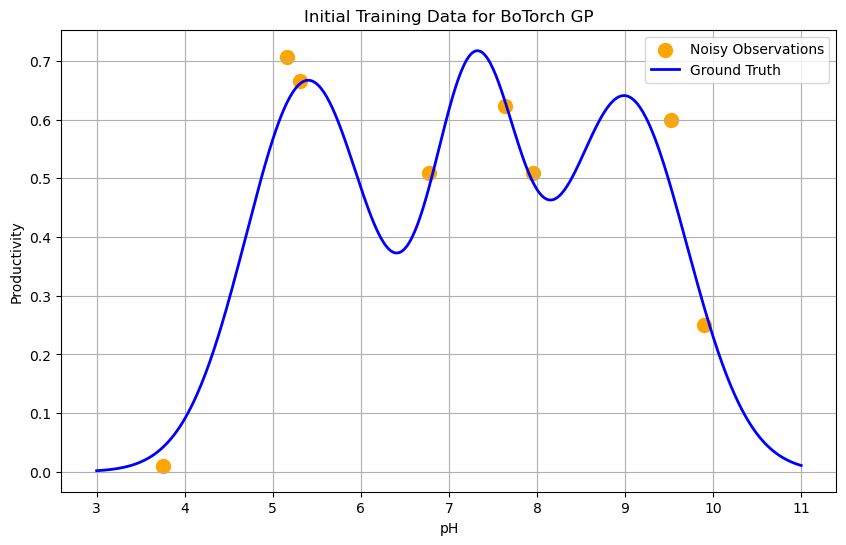

In [6]:
num_points = 8
x_init = generate_sobol_points(num_points, bounds=bounds_pH, seed=SEED)
enzyme_params = list(extract_widget_values(enzyme_sliders).values())


y_init = generate_noisy_observations(
    x=x_init,
    truth_fn=enzyme_truth,
    noise_fn=symmetric_noise,
    truth_params=list(extract_widget_values(enzyme_sliders).values()),  # Enzyme parameters from your sliders
    noise_params=noise_params,  # Noise parameters from your noise sliders
    seed=SEED,
)

train_x = torch.tensor(x_init, dtype=dtype).unsqueeze(-1)
train_y = torch.tensor(y_init, dtype=dtype).unsqueeze(-1)


plt.figure(figsize=(10, 6))
plt.scatter(
    train_x.numpy(), train_y.numpy(), color="orange", label="Noisy Observations", s=100
)
pH_range = np.linspace(3, 11, 500)


ground_truth, _ = enzyme_truth(pH_range, list(extract_widget_values(enzyme_sliders).values()))
plt.plot(
    pH_range,
    ground_truth,
    color="blue",
    label="Ground Truth",
    linewidth=2,
)
plt.title("Initial Training Data for BoTorch GP")
plt.xlabel("pH")
plt.ylabel("Productivity")
plt.legend()
plt.grid()
plt.show()


Make reasonable prepearations for the small dataset (normalize)
Fit a Botorch GP with RBF Kernel, length scale prior half the distance von xmax-xmin

# Implement here

### ConstantMean(train_y.mean())

In [7]:
class CascadeGP(SingleTaskGP):
    def __init__(self, train_x, train_y, bounds):
        super().__init__(train_x, train_y, outcome_transform=Standardize(m=1))

        self.covar_module = ScaleKernel(
            RBFKernel(
                lengthscale_prior=LogNormalPrior(
                    loc=np.log(np.abs(bounds[0] - bounds[1])) / 4, scale=0.2
                )
            )
        )
        self.mean_module = ConstantMean()
        self.mean_module.constant.data.fill_(train_y.mean().item())


def fit_gp_model(train_x, train_y, bounds):
    """
    Fit a Gaussian Process model to the training data.

    Parameters
    ----------
    train_x : torch.Tensor
        The training inputs.
    train_y : torch.Tensor
        The training targets.

    Returns
    -------
    model : CustomSingleTaskGP
        The fitted Gaussian Process model.
    """
    model = CascadeGP(train_x, train_y, bounds)

    # Define the Marginal Log Likelihood (MLL)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_mll(mll)

    return model


gp_model = fit_gp_model(train_x=train_x, train_y=train_y, bounds=bounds_pH)

/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


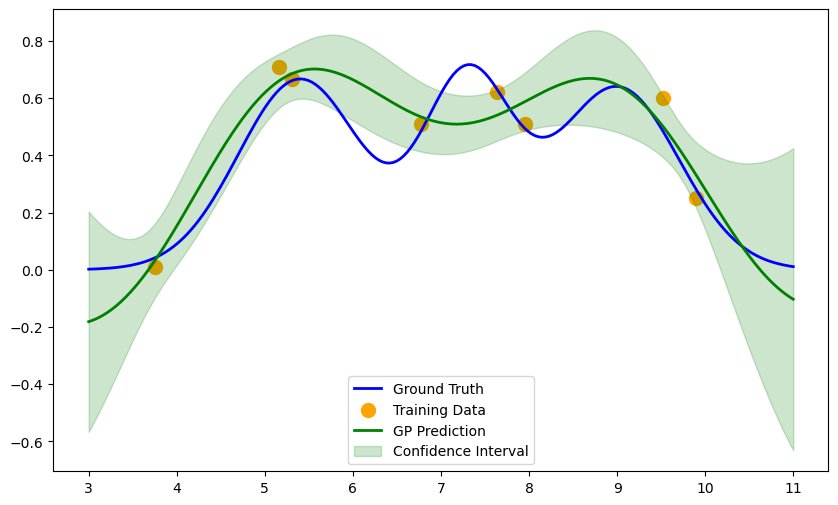

In [8]:
bounds_ax = (3, 11)

x_test = torch.linspace(bounds_ax[0], bounds_ax[1], 800).unsqueeze(-1)

gp_model.eval()
with torch.no_grad():
    posterior = gp_model.posterior(x_test)
    mean = posterior.mean
    lower, upper = posterior.mvn.confidence_region()

mean = mean.numpy()
lower = lower.numpy()
upper = upper.numpy()

plt.figure(figsize=(10, 6))

# Plot ground truth
x_ground_truth = np.linspace(bounds_ax[0], bounds_ax[1], 200)
y_ground_truth, _ = enzyme_truth(x_ground_truth, enzyme_params)
plt.plot(
    x_ground_truth, y_ground_truth, label="Ground Truth", color="blue", linewidth=2
)

# Plot training data
plt.scatter(
    train_x.numpy(), train_y.numpy(), color="orange", label="Training Data", s=100
)


plt.plot(x_test.numpy(), mean, label="GP Prediction", color="green", linewidth=2)

# Plot confidence intervals
plt.fill_between(
    x_test.squeeze(-1).numpy(),
    lower,
    upper,
    alpha=0.2,
    color="green",
    label="Confidence Interval",
)

plt.legend()
plt.show()

## The Acquisition functions

In [9]:
def perform_EI(train_x, train_y, bounds, num_candidates):
    gp_model = fit_gp_model(train_x, train_y, bounds)
    best_f = train_y.max().item()
    bounds = torch.tensor(bounds, dtype=dtype).view(2,-1)
    qei = qExpectedImprovement(model=gp_model, best_f=best_f)
    candidates, _ = optimize_acqf(
        acq_function=qei,
        bounds=bounds,
        q=num_candidates,
        num_restarts=10,
        raw_samples=256,
    )
    return candidates, gp_model, qei


In [10]:
def perform_logEI(train_x, train_y, bounds, num_candidates):
    gp_model = fit_gp_model(train_x, train_y, bounds)
    best_f = train_y.max().item()
    bounds = torch.tensor(bounds, dtype=dtype).view(2,-1)
    qlog_ei = qLogExpectedImprovement(model=gp_model, best_f=best_f)
    candidates, _ = optimize_acqf(
        acq_function=qlog_ei,
        bounds=bounds,
        q=num_candidates,
        num_restarts=10,
        raw_samples=256,
    )
    return candidates, gp_model, qlog_ei

## BO Loops

In [11]:
def plot_gp_and_acquisition(
    gp_model, train_x, train_y, bounds, acquisition_fn, candidates, truth_fn=None, truth_params=None
):
    """
    Plots the GP model's predictions and the acquisition function.

    Parameters
    ----------
    gp_model : SingleTaskGP
        The Gaussian Process model to plot.
    train_x : torch.Tensor
        Training inputs.
    train_y : torch.Tensor
        Training outputs.
    bounds : torch.Tensor
        Bounds of the search space as a tensor of shape (2, d).
    acquisition_fn : callable
        The acquisition function, must be a callable.
    truth_fn : callable, optional
        Ground truth function for comparison (if available).
    truth_params : dict, optional
        Parameters for the truth function (if any).
    """
    
    x_test = torch.linspace(bounds[0], bounds[1], 500).unsqueeze(-1)

    # Obtain mean and variance of the model's predictions
    with torch.no_grad():
        posterior = gp_model.posterior(x_test)
        mean = posterior.mean.numpy()
        lower, upper = posterior.mvn.confidence_region()

        acquisition_values = acquisition_fn(x_test.unsqueeze(-2)).detach().numpy().squeeze()

    # Optionally evaluate the ground truth function
    if truth_fn is not None and truth_params is not None:
        total_rate, rates = truth_fn(x_test.numpy(), **truth_params)
        truth_values = total_rate

    # Plot the GP mean and confidence intervals
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [2,1]}, sharex=True)

    ax1.scatter(train_x.numpy(), train_y.numpy(), color="orange", label="Training Data", s=100)
    ax1.plot(x_test.numpy(), mean, color="green", label="GP Mean")
    ax1.fill_between(
        x_test.squeeze(-1).numpy(),
        lower.numpy(),
        upper.numpy(),
        color="green",
        alpha=0.2,
        label="Confidence Interval",
    )
    if truth_fn is not None and truth_params is not None:
        ax1.plot(x_test.numpy(), truth_values, color="blue", label="Ground Truth", linestyle="--")
    

    # Plot the acquisition function
    ax2.plot(x_test.squeeze(-1).numpy(), acquisition_values, color="blue")
    ax2.yaxis.set_ticks([])
    ax2.set_ylabel("Expected Improvement")

    for ax in (ax1, ax2):
        ax.axvline(
            x=candidates,
            color="red",
            linestyle="-",
            linewidth=2,
            alpha=0.5,
            label="Proposed Candidate",
        )
    
    ax1.set_xlabel("pH [-]")
    ax1.set_ylabel("reaction rate [mmol/min]")
    ax1.legend()

    plt.tight_layout()
    plt.show()


/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


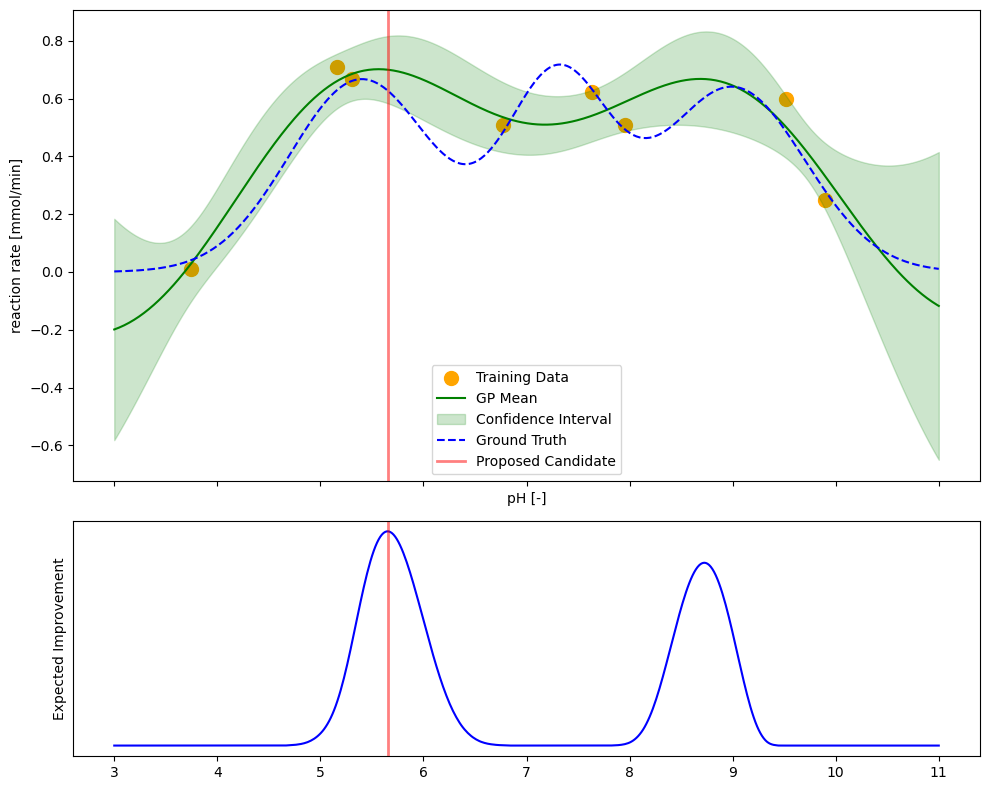

In [12]:
candidates, gp_model, acquisition_fn = perform_EI(
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_ax,
    num_candidates=1,
)

enzyme_params = list(extract_widget_values(enzyme_sliders).values())

plot_gp_and_acquisition(
    gp_model=gp_model,
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_ax,
    acquisition_fn=acquisition_fn,
    candidates=candidates,
    truth_fn=enzyme_truth,
    truth_params={"enzyme_params": enzyme_params},
    )

/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


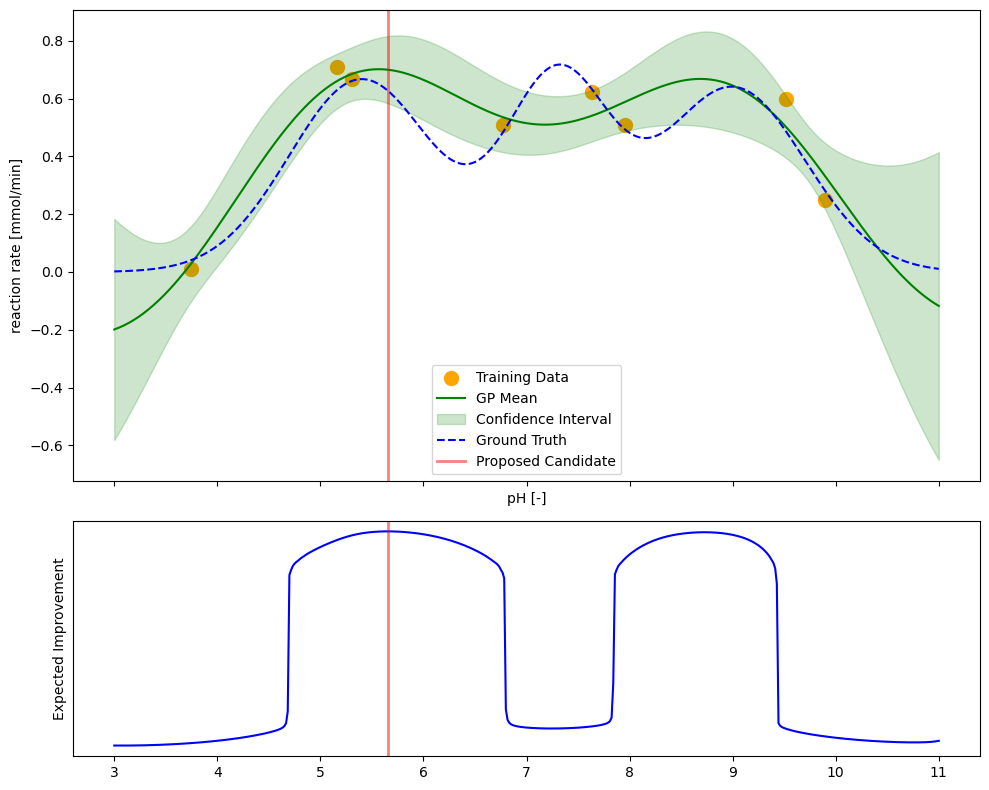

In [13]:
candidates, gp_model, acquisition_fn = perform_logEI(
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_ax,
    num_candidates=1,
)

enzyme_params = list(extract_widget_values(enzyme_sliders).values())

plot_gp_and_acquisition(
    gp_model=gp_model,
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_ax,
    acquisition_fn=acquisition_fn,
    candidates=candidates,
    truth_fn=enzyme_truth,
    truth_params={"enzyme_params": enzyme_params},
    )

In [14]:
def perform_TS(train_x, train_y, bounds, num_candidates, seed=SEED):

    torch.manual_seed(seed)

    gp_model = fit_gp_model(train_x, train_y)

    
    candidate_x = torch.linspace(bounds[0][0], bounds[0][1], 1000).unsqueeze(-1)

    posterior = gp_model.posterior(candidate_x)
    sampled_function = posterior.rsample(torch.Size([num_candidates])).squeeze(-1) # shape: num_candidates x num_points

    
    max_indices = torch.argmax(sampled_function, dim=-1)
    candidates = candidate_x[max_indices]

    return candidates, gp_model, sampled_function

In [15]:
def perform_bo(train_x, train_y, bounds, num_candidates, num_rounds, method="EI", seed=None):
    """
    Perform multiple rounds of Bayesian Optimization.

    Parameters:
    -----------
    train_x : torch.Tensor
        Initial training inputs.
    train_y : torch.Tensor
        Initial training outputs.
    bounds : torch.Tensor
        Input domain bounds.
    num_candidates : int
        Number of candidates to propose in each round.
    num_rounds : int
        Number of BO rounds.
    method : str, optional
        Optimization method: "EI" (Expected Improvement) or "TS" (Thompson Sampling).
    seed : int, optional
        Random seed for reproducibility.
    """
    for round_idx in range(num_rounds):
        print(f"Round {round_idx + 1}/{num_rounds}")

        # Perform the chosen acquisition strategy
        if method == "EI":
            candidates, gp_model, acquisition_fn = perform_EI(
                train_x, train_y, bounds, num_candidates
            )
            sampled_function = None  # EI does not use sampled functions
        elif method == "TS":
            candidates, gp_model, sampled_function = perform_TS(
                train_x, train_y, bounds, num_candidates, seed=seed
            )
            acquisition_fn = None  # TS does not use acquisition functions
        else:
            raise ValueError("Unsupported method. Use 'EI' or 'TS'.")
        
        enzyme_params = list(extract_widget_values(enzyme_sliders).values())
        # Simulate observing new data
        print("Running into observation")
        new_y = generate_noisy_observations(
            x=candidates.numpy().flatten(),
            bounds=bounds,
            truth_fn=enzyme_truth,
            noise_fn=symmetric_noise,
            truth_params=enzyme_params,
            noise_params=noise_params,
            seed=seed + round_idx if seed is not None else None,
        )

        new_y = torch.tensor(new_y, dtype=dtype).reshape(-1, 1)
        print(train_y)
        # Update training data
        train_x = torch.cat([train_x, candidates], dim=0)
        train_y = torch.cat([train_y, new_y], dim=0)
        print(train_y)
        


        # Plot results
        plot_gp_and_acquisition(
            gp_model=gp_model,
            train_x=train_x,
            train_y=train_y,
            bounds=bounds,
            acquisition_fn=acquisition_fn,
            candidates=candidates,
            truth_fn=enzyme_truth,
            truth_params={"enzyme_params": enzyme_params},
        )


Round 1/5
Running into observation
[0.62759364]
[nan]
tensor([[0.6227],
        [0.5091],
        [0.0102],
        [0.2501],
        [0.5999],
        [0.7076],
        [0.6665],
        [0.5084]], dtype=torch.float64)
tensor([[0.6227],
        [0.5091],
        [0.0102],
        [0.2501],
        [0.5999],
        [0.7076],
        [0.6665],
        [0.5084],
        [   nan]], dtype=torch.float64)


/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/maximiliansiska/miniforge3/envs/bo-paper/lib/python3.12/site-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/maximiliansiska/repos/BO_Empirical_Examples/utils.py:431: RuntimeWarning: invalid value encountered in divide
  x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))


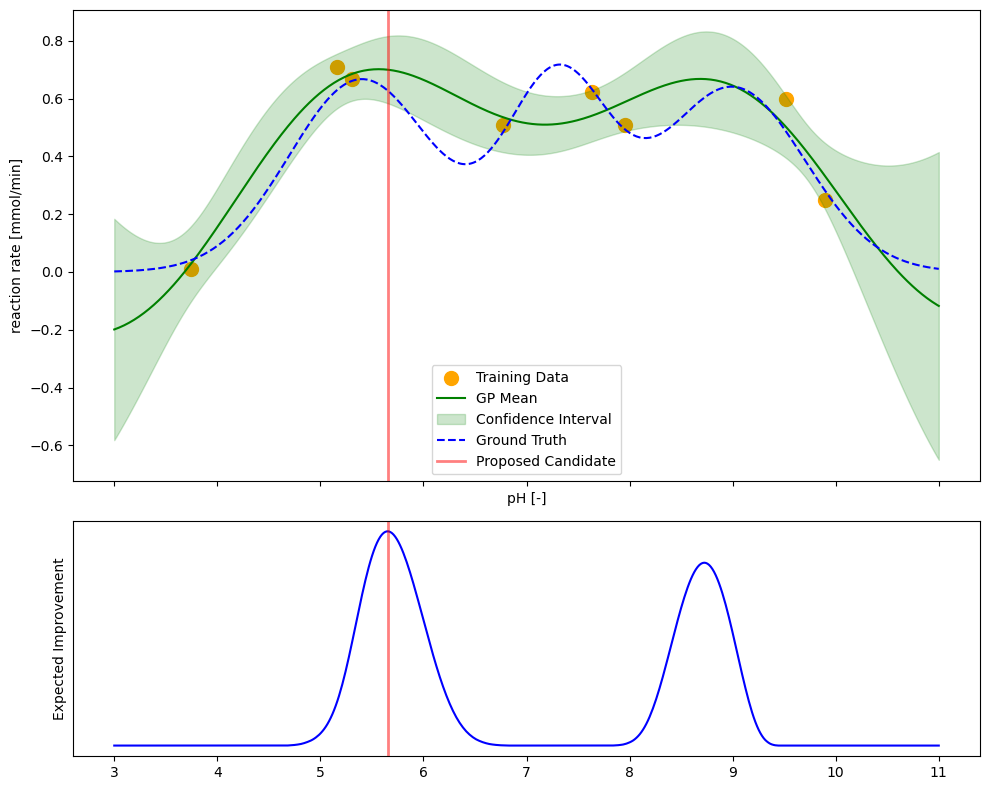

Round 2/5


InputDataError: Input data contains NaN values.

In [16]:
# Define initial training data, bounds, and parameters


num_candidates = 1
num_rounds = 5
method = "EI"
seed = 42

# Perform Bayesian Optimization
perform_bo(
    train_x=train_x,
    train_y=train_y,
    bounds=bounds_ax,
    num_candidates=num_candidates,
    num_rounds=num_rounds,
    method=method,
    seed=seed,
)
